# Variational Autoencoder (VAE)
- 참고문헌:  
    - https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f  
    - https://wikidocs.net/271472


In [1]:
import torch
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

## MNIST datasets download

In [3]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = './datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100.0%
100.0%
100.0%
100.0%


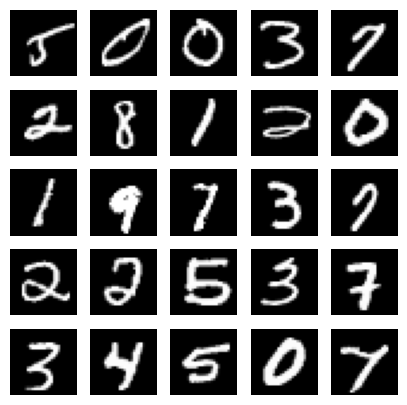

In [8]:
# get 25 sample training images for visualization
image = next(iter(train_loader))

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 
sample_images[0].shape

fig, ax = plt.subplots(5, 5, figsize=(5, 5))
idx = 0
for i in range(5):
    for j in range(5):
        
        ax[i, j].imshow(sample_images[idx].numpy(), cmap='gray')
        ax[i, j].axis('off')
        idx += 1

plt.show()

## Variational autoencoder (VAE) class

In [13]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

## VAE Training

In [14]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [15]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KL = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KL

In [16]:
def train(model, optimizer, epochs, device):
    model.train()
    
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, 784).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    torch.save(model.state_dict(), "VAE_50ep.pt")
    # return overall_loss

train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  174.45090670322935
	Epoch 2 	Average Loss:  157.49938303748434
	Epoch 3 	Average Loss:  152.55386867109246
	Epoch 4 	Average Loss:  149.60186637559997
	Epoch 5 	Average Loss:  147.56350603871036
	Epoch 6 	Average Loss:  146.01252807413397
	Epoch 7 	Average Loss:  144.9282400354758
	Epoch 8 	Average Loss:  143.69806099358306
	Epoch 9 	Average Loss:  142.80171723380113
	Epoch 10 	Average Loss:  141.87219102149416
	Epoch 11 	Average Loss:  141.12779009938438
	Epoch 12 	Average Loss:  140.6047676465985
	Epoch 13 	Average Loss:  139.91330740035477
	Epoch 14 	Average Loss:  139.5483669886008
	Epoch 15 	Average Loss:  139.18281060882722
	Epoch 16 	Average Loss:  138.60783173779214
	Epoch 17 	Average Loss:  138.3242788925553
	Epoch 18 	Average Loss:  137.9990427242018
	Epoch 19 	Average Loss:  137.74964697021076
	Epoch 20 	Average Loss:  137.44876429791842
	Epoch 21 	Average Loss:  137.3173087470002
	Epoch 22 	Average Loss:  136.95083764281614
	Epoch 23 	Average Loss: 

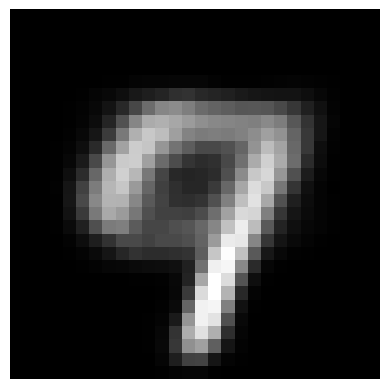

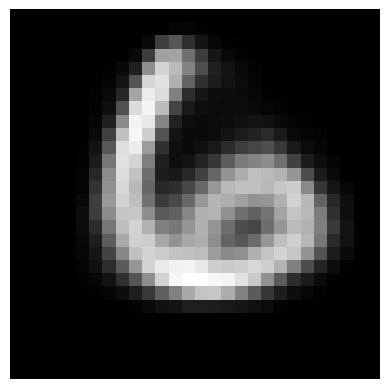

(None, None)

In [20]:
model = VAE().to(device)
model.load_state_dict(torch.load("VAE_50ep.pt"))

def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

## VAE latent space

In [27]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)

C:\Users\nbumk\AppData\Local\Temp\ipykernel_15280\1901758076.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit


KeyboardInterrupt: 